# 1. Sentiment

## a. Analysis

In [2]:
import pandas as pd
from transformers import pipeline

In [3]:
dataset = pd.read_csv("../../Data Collection/Google Reviews/google_reviews_no_index.csv")
reviews = list(dataset["Reviews"])
reviews

['enak banget tempatnya buat adain acara komunitas gitu, bersih, accessible dan luas juga tempatnya. Makasi cakap!',
 'kemarin abis ke cakap, tempatnya cozy dan nyaman banget dipake buat belajar buat meeting buat apapun',
 'Ikut kartu prakerja agak nyesel ngambil kelas di sini, waktu pengumpulan tugasnya ga pasti yang mana. Terbuang sia2 waktu yang saya gunakan☹. Waktu hitung mundur masih ada untuk mengumpul tugas, tetapi sudah tidak bisa. Tidak ada rasa empati kepada siswa dalam membantu menyelesaikan kelas. Pemberian informasi deadline tugas tidak lengkap. Semoga ke depannya waktu hitung mundur dan adminnya sama dalam memberikan waktu deadline tugas akhir.',
 'Tempatnya nyaman bikin betah dan cocok untuk belajar',
 'tempatnya bener bener nyamann bikin pengunjung betah belajar disanaa',
 'Tempat terbaik untuk mengasah kemampuan. Bekerja sambil belajar.',
 '26 kredit hangus tanpa pemberitahuan sebelumnya',
 'Belajarnya nyaman krn jadwal bisa fleksibel, tutor dan materinya mudah dimenge

In [4]:
def analyze_sentiment(text_to_analyze):
    # Specify the model and revision explicitly
    model_name = "w11wo/indonesian-roberta-base-sentiment-classifier"

    # Load the sentiment analysis pipeline with explicit model
    sentiment_analyzer = pipeline(
        "sentiment-analysis",
        model=model_name,
        tokenizer=model_name
    )

    # Perform sentiment analysis
    sentiment_result = sentiment_analyzer(text_to_analyze)

    return sentiment_result

In [ ]:
sentiments = analyze_sentiment(reviews)

In [6]:
def get_df(sentences, sentiments):
    sents = {
        'review': sentences,
        'label': [senti['label'].upper() for senti in sentiments],
        'score': [senti['score'] for senti in sentiments]
    }

    df = pd.DataFrame(sents)
    return df

In [7]:
senti_df = get_df(reviews, sentiments)
senti_df.head()

,review,label,score
0,enak banget tempatnya buat adain acara komunit...,POSITIVE,0.998875
1,"kemarin abis ke cakap, tempatnya cozy dan nyam...",POSITIVE,0.997210
2,Ikut kartu prakerja agak nyesel ngambil kelas ...,NEGATIVE,0.998917
3,Tempatnya nyaman bikin betah dan cocok untuk b...,POSITIVE,0.999309
4,tempatnya bener bener nyamann bikin pengunjung...,POSITIVE,0.999395


In [8]:
senti_df.to_csv("../../Data Analysis/Google Reviews/google_reviews_sentiment.csv", index=False)

## b. Visualization

In [9]:
import altair as alt
import matplotlib.pyplot as plt

### 1) sentiments distribution

In [10]:
def pie_chart(poss, negs, neuts):
    total = poss + negs
    poss_perc = str(poss/total*100)+"%"
    negs_perc = str(negs/total*100)+"%"
    neuts_perc = str(neuts/total*100)+"%"

    source = pd.DataFrame({
        "Label": ["Positive", "Negative", "Neutral"],
        "Count": [poss, negs, neuts],
        "Percentage": [poss_perc, negs_perc, neuts_perc]
    })

    pie = alt.Chart(source).mark_arc().encode(
        theta="Count",
        color=alt.Color(
            "Label",
            scale=alt.Scale(
                domain=["Positive", "Negative", "Neutral"],
                range=["#19c2fa", "#fc3f3f", "#808080"]
            )),
        tooltip=["Label", "Count", "Percentage"]
    )

    return pie

In [11]:
def show_bar_chart(labels, counts, title):
    fig, ax = plt.subplots(figsize=(8, 6))
    bars = ax.bar(labels, counts, color=['#2394f7', '#f72323', '#fac343'])

    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom')

    ax.grid(axis='y', linestyle='--', alpha=0.7)

    ax.set_xlabel('Sentimen')
    ax.set_ylabel('Jumlah')
    ax.set_title(title)

    plt.show()

In [12]:
label_count = senti_df['label'].value_counts()
poss = label_count.get('POSITIVE')
negs = label_count.get('NEGATIVE')
neuts = label_count.get("NEUTRAL")

pie = pie_chart(poss, negs, neuts)
pie.interactive()

alt.Chart(...)

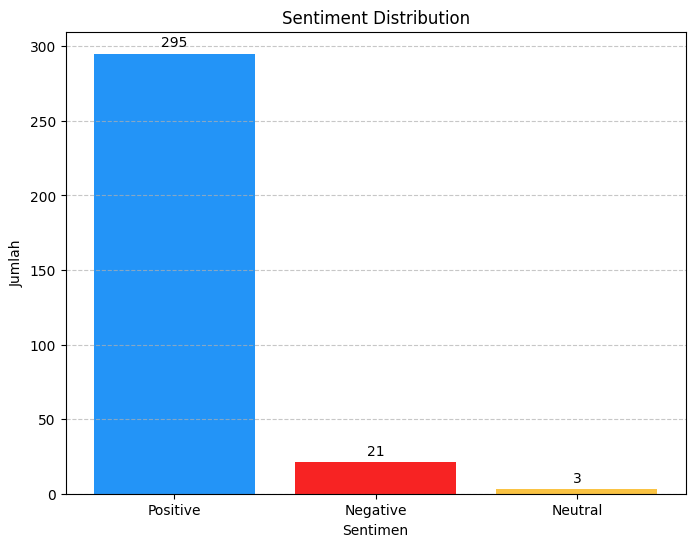

In [13]:
show_bar_chart(
    ["Positive", "Negative", "Neutral"],
    [poss, negs, neuts],
    "Sentiment Distribution"
)

### 2) rating prediction

In [14]:
# Removing neutral sentiments because they aren't affecting
# the positivity or negativity
pos_neg_df = senti_df[senti_df["label"] != "NEUTRAL"]
pos_neg_df

,review,label,score
0,enak banget tempatnya buat adain acara komunit...,POSITIVE,0.998875
1,"kemarin abis ke cakap, tempatnya cozy dan nyam...",POSITIVE,0.997210
2,Ikut kartu prakerja agak nyesel ngambil kelas ...,NEGATIVE,0.998917
3,Tempatnya nyaman bikin betah dan cocok untuk b...,POSITIVE,0.999309
4,tempatnya bener bener nyamann bikin pengunjung...,POSITIVE,0.999395
...,...,...,...
314,insightful!!,NEGATIVE,0.910058
315,Bagus,POSITIVE,0.930638
316,good,POSITIVE,0.999060
317,sangat membantu,POSITIVE,0.995917


In [15]:
pos_df = pd.DataFrame({
    "review": pos_neg_df["review"],
    "positivity": senti_df.apply(lambda row: 1 - row['score'] if row['label'] == 'NEGATIVE' else row['score'], axis=1)
})

pos_df.head()

,review,positivity
0,enak banget tempatnya buat adain acara komunit...,0.998875
1,"kemarin abis ke cakap, tempatnya cozy dan nyam...",0.997210
2,Ikut kartu prakerja agak nyesel ngambil kelas ...,0.001083
3,Tempatnya nyaman bikin betah dan cocok untuk b...,0.999309
4,tempatnya bener bener nyamann bikin pengunjung...,0.999395


In [16]:
positivity = pos_df["positivity"]

normalized_scores = [(score * 4) + 1 for score in (positivity)]

source = pd.DataFrame({
    "score": normalized_scores
})
alt.Chart(source).mark_bar().encode(
    alt.X("score:Q", title="Ratings", bin=True),
    y='count()',
)

alt.Chart(...)

# 2. Topic Modelling

In [17]:
import pyLDAvis
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from nlp_id.stopword import StopWord
from gensim.parsing.preprocessing import preprocess_string
import pyLDAvis.gensim_models as gensimvis

## a. Preprocessing

In [18]:
documents = reviews

# Remove Indonesian stop words
stopword = StopWord()
stop_removed = [stopword.remove_stopword(text) for text in reviews]

# Preprocess text
processed_docs = [preprocess_string(doc) for doc in stop_removed]

# Create dictionary
dictionary = corpora.Dictionary(processed_docs)

# Create bag-of-words corpus
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

## b. Training and Visualization

In [19]:
# Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, passes=500)

In [20]:
# Visualize topics
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

## c. Coherence Score

In [21]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.506131298832665


# 3. Word Cloud

In [22]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nlp_id.tokenizer import Tokenizer

## a. Preprocessing

In [23]:
def preprocess_text(reviews):
    tokenizer = Tokenizer()
    stopword = StopWord()
    stop_words = stopword.get_stopword()
    
    text = " ".join(reviews)
    tokens = [tokenizer.tokenize(text.lower())][0]
    tokens = [token for token in tokens if token.isalpha()
              and token not in stop_words]
    return tokens

In [24]:
tokens = preprocess_text(reviews)

In [25]:
from collections import Counter

top_5_tokens = Counter(tokens).most_common(5)
tokens_5 = [token[0] for token in top_5_tokens]
counts_5 = [token[1] for token in top_5_tokens]

## b. Visualization

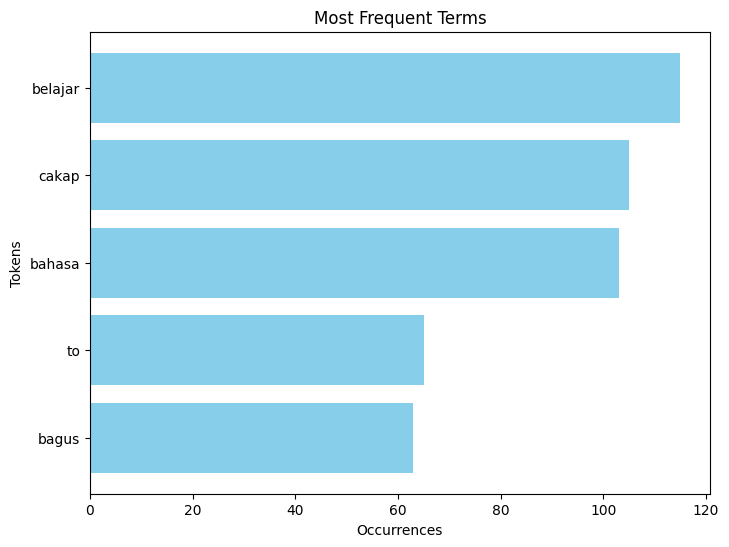

In [26]:
plt.figure(figsize=(8, 6))
plt.barh(tokens_5, counts_5, color='skyblue')
plt.xlabel('Occurrences')
plt.ylabel('Tokens')
plt.title('Most Frequent Terms')
plt.gca().invert_yaxis()
plt.show()

In [27]:
def generate_wordcloud(words):
    # Generate WordCloud for adjectives
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white').generate(words)

    # Display the WordCloud using matplotlib
    _, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')

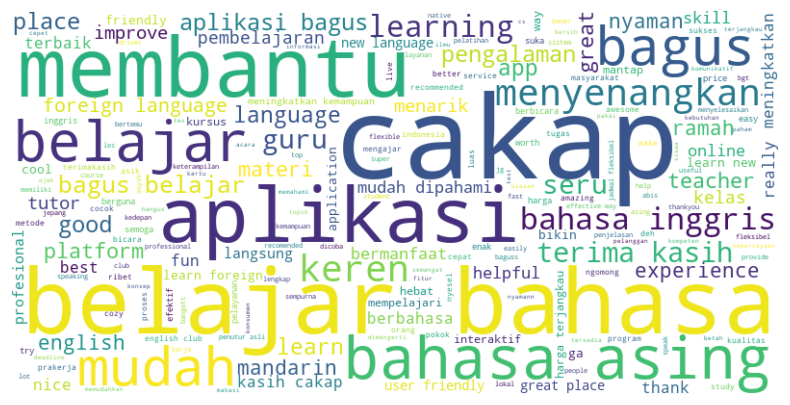

In [28]:
text = " ".join(tokens)
generate_wordcloud(text)